In [1]:
from numpy.random import seed
seed(101)
from tensorflow import set_random_seed
set_random_seed(101)

import pandas as pd
import numpy as np


import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.optimizers import Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
IMAGE_SIZE = 96
IMAGE_CHANNELS = 3

SAMPLE_SIZE = 80000

In [3]:
os.listdir('../cancer cells detection')

['test',
 'train',
 'new_directory',
 'Untitled.ipynb',
 'sample_submission.csv',
 'train_labels.csv',
 'asdas',
 '.ipynb_checkpoints',
 'test.zip']

In [4]:
print('Images in train dir {}' . format(len(os.listdir('../cancer cells detection/train'))))
print('Images in test dir {}' . format(len(os.listdir('../cancer cells detection/test'))))

Images in train dir 220025
Images in test dir 57458


In [5]:
df_data = pd.read_csv('../cancer cells detection/train_labels.csv')
print(df_data.shape)

# removing this image because it caused a training error previously
df_data[df_data['id'] != 'dd6dfed324f9fcb6f93f46f32fc800f2ec196be2']

# removing this image because it's black
df_data[df_data['id'] != '9369c7278ec8bcc6c880d99194de09fc2bd4efbe']
print(df_data.shape)

(220025, 2)
(220025, 2)


In [6]:
df_data.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [7]:
df_data.sample(5)

,id,label
51455,edc4ebe232a927ae9feaa55b27335ab8d4ea05b4,0
102998,f5bbed2a9cb38281f22dc38e42d336ee5aec5459,0
192459,287e803e1fac3ecd05586d2595aee1bffa034540,0
19040,1b2ca66bf1a35e17140a81e9f7c198e8c4da729b,1
22191,e2193a775d7bf0897401851eed9624f007168b96,1


In [8]:
df_data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [9]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    

    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(4*figure_cols,4*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

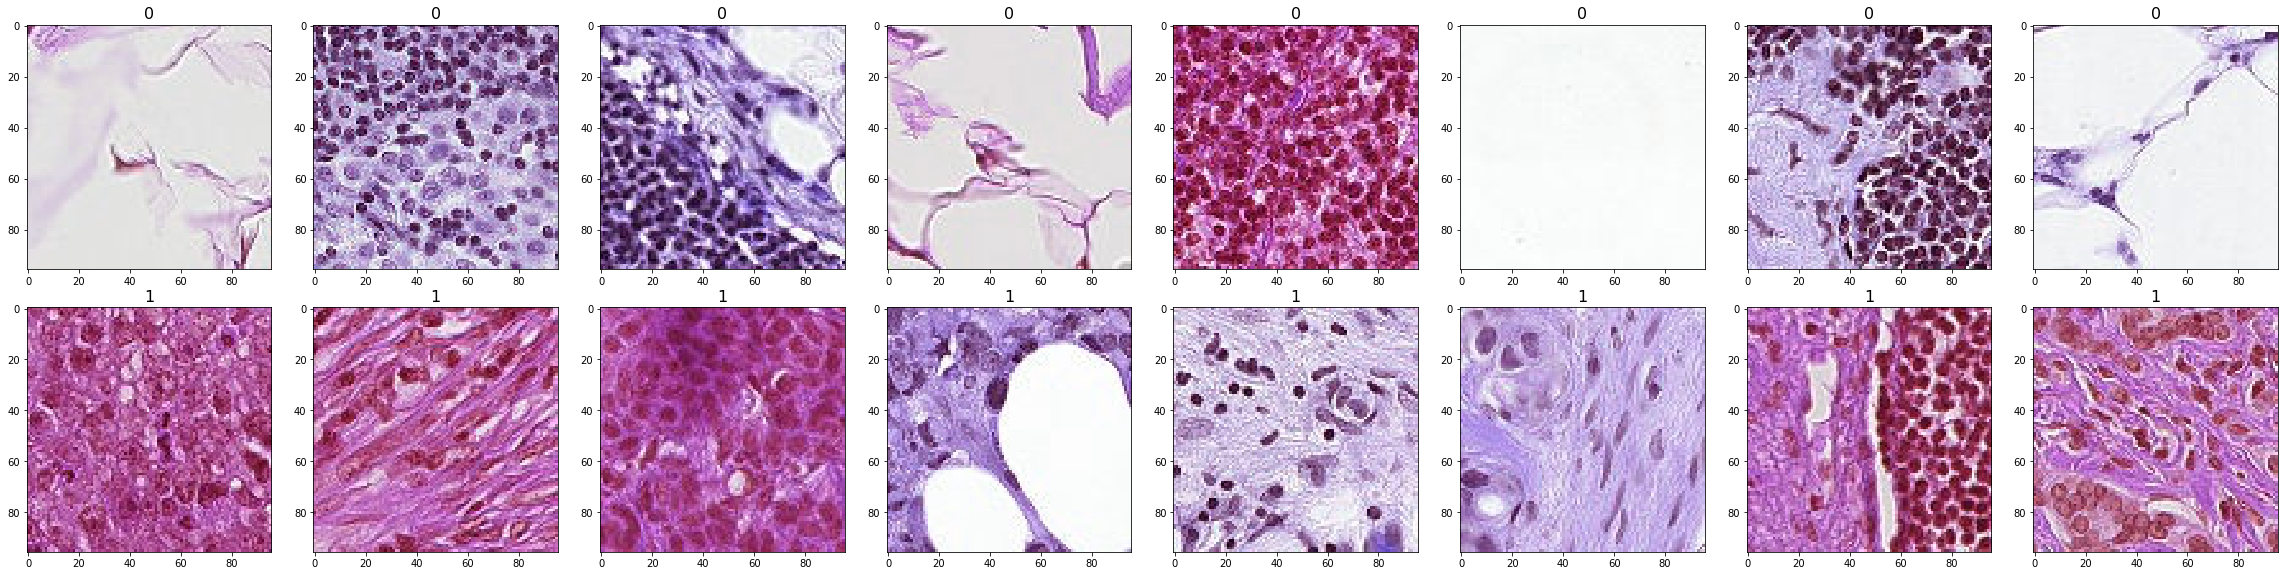

In [10]:
IMAGE_PATH = '../cancer cells detection/train/' 

draw_category_images('label',8, df_data, IMAGE_PATH)

In [11]:
#creating an 80000 set of images with label 1 and label 0
# take a random sample of class 0 with size equal to num samples in class 1
df_0 = df_data[df_data['label'] == 0].sample(SAMPLE_SIZE, random_state = 101)
df_1 = df_data[df_data['label'] == 1].sample(SAMPLE_SIZE, random_state = 101)

# concat the dataframes
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)

df_data['label'].value_counts()

1    80000
0    80000
Name: label, dtype: int64

In [12]:
y = df_data['label']

df_train, df_val = train_test_split(df_data, test_size=0.10, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(144000, 2)
(16000, 2)


In [13]:
df_train['label'].value_counts()

1    72000
0    72000
Name: label, dtype: int64

In [14]:
df_val['label'].value_counts()

1    8000
0    8000
Name: label, dtype: int64

In [16]:
# Create a new directory
base_dir = 'new_directory'
os.mkdir(base_dir)

#create two folders, train and val, with tumor tissue and no tumor tissue respectively 

train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)
val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

# create new folders inside train_dir, for each class
no_tumor_tissue = os.path.join(train_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(train_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

# create new folders inside val_dir, for each class
no_tumor_tissue = os.path.join(val_dir, 'a_no_tumor_tissue')
os.mkdir(no_tumor_tissue)
has_tumor_tissue = os.path.join(val_dir, 'b_has_tumor_tissue')
os.mkdir(has_tumor_tissue)

In [17]:
df_data.set_index('id', inplace=True)

In [19]:
# Get a list of train and val images
train_list = list(df_train['id'])
val_list = list(df_val['id'])

# Transfer the train images to newly created folders
for image in train_list:
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    
    # source path to image
    src = os.path.join('../cancer cells detection/train', fname)
    # destination path to image
    dst = os.path.join(train_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)


# Transfer the val images to newly created folders
for image in val_list:
    # the id in the csv file does not have the .tif extension therefore we add it here
    fname = image + '.tif'
    # get the label for a certain image
    target = df_data.loc[image,'label']
    
    # these must match the folder names
    if target == 0:
        label = 'a_no_tumor_tissue'
    if target == 1:
        label = 'b_has_tumor_tissue'
    

    # source path to image
    src = os.path.join('../cancer cells detection/train', fname)
    # destination path to image
    dst = os.path.join(val_dir, label, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [22]:
print('Images in train dir, no tumor tissue {}' . format(len(os.listdir('new_directory/train_dir/a_no_tumor_tissue'))))
print('Images in train dir, tumor tissue {}' . format(len(os.listdir('new_directory/train_dir/b_has_tumor_tissue'))))
print('Images in val dir, no tumor tissue {}' . format(len(os.listdir('new_directory/val_dir/a_no_tumor_tissue'))))
print('Images in val dir, tumor tissue {}' . format(len(os.listdir('new_directory/val_dir/b_has_tumor_tissue'))))

Images in train dir, no tumor tissue 72000
Images in train dir, tumor tissue 72000
Images in val dir, no tumor tissue 8000
Images in val dir, tumor tissue 8000


In [23]:
train_path = 'new_directory/train_dir'
valid_path = 'new_directory/val_dir'
test_path = '../cancer cells detection/test'

In [24]:
datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=train_batch_size,
                                        class_mode='categorical')

val_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=val_batch_size,
                                        class_mode='categorical')

# Note: shuffle=False causes the test dataset to not be shuffled
test_gen = datagen.flow_from_directory(valid_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 144000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.
Found 16000 images belonging to 2 classes.


In [25]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 92, 92, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 90, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 43, 43, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 41, 41, 64)        36928     
__________

In [26]:
model.compile(Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 64 #10, or 32 for better accuracy
val_batch_size = 64 #10, or 32 for better accurac

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)
train_steps

2250.0

In [31]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, 
                    validation_data=val_gen,
                    validation_steps=val_steps,
                    epochs=2, verbose=1, #epoch increase to maybe 10-20 range
                   callbacks=callbacks_list)

Epoch 1/2
2250/2250 [==============================] - 1858s 826ms/step - loss: 0.4805 - acc: 0.7811 - val_loss: 0.5226 - val_acc: 0.7591

Epoch 00001: val_acc improved from -inf to 0.75906, saving model to model.h5
Epoch 2/2
2250/2250 [==============================] - 1870s 831ms/step - loss: 0.4468 - acc: 0.7966 - val_loss: 0.4760 - val_acc: 0.7887

Epoch 00002: val_acc improved from 0.75906 to 0.78869, saving model to model.h5


In [32]:
model.load_weights('model.h5')

val_loss, val_acc = model.evaluate_generator(test_gen, steps=len(df_val))

print('val_loss:', val_loss)
print('val_acc:', val_acc)

val_loss: 0.476007865606
val_acc: 0.7886875


<Figure size 432x288 with 0 Axes>

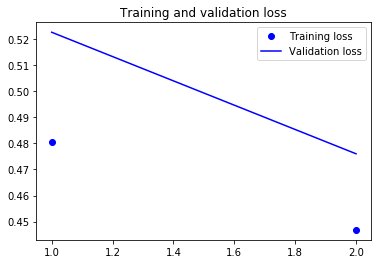

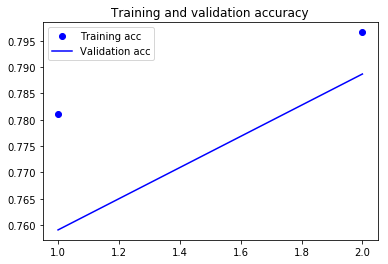

<Figure size 432x288 with 0 Axes>

In [33]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#LOL to the figure below

In [34]:
predictions = model.predict_generator(test_gen, steps=len(df_val), verbose=1)

16000/16000 [==============================] - 226s 14ms/step


In [35]:
df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

df_preds.head()

,no_tumor_tissue,has_tumor_tissue
0,0.946629,0.053371
1,0.613772,0.386228
2,0.930029,0.069971
3,0.220143,0.779857
4,0.895758,0.104242


In [36]:
from sklearn.metrics import roc_auc_score

# Get the true labels
y_true = test_gen.classes
# Get the predicted labels as probabilities
y_pred = df_preds['has_tumor_tissue']

roc_auc_score(y_true, y_pred)

0.88215425781250001

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [38]:
test_labels = test_gen.classes
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))
test_gen.class_indices

{'a_no_tumor_tissue': 0, 'b_has_tumor_tissue': 1}

Confusion matrix, without normalization
[[5630 2370]
 [1011 6989]]


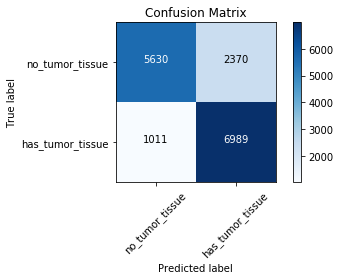

In [39]:
# Define the labels of the class indices. These need to match the 
# order shown above.
cm_plot_labels = ['no_tumor_tissue', 'has_tumor_tissue']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [40]:
from sklearn.metrics import classification_report

# Generate a classification report

# For this to work we need y_pred as binary labels not as probabilities
y_pred_binary = predictions.argmax(axis=1)

report = classification_report(y_true, y_pred_binary, target_names=cm_plot_labels)

print(report)

                  precision    recall  f1-score   support

 no_tumor_tissue       0.85      0.70      0.77      8000
has_tumor_tissue       0.75      0.87      0.81      8000

     avg / total       0.80      0.79      0.79     16000



In [42]:
shutil.rmtree('new_directory')

In [43]:
test_dir = 'test_dir'
os.mkdir(test_dir)
    
# create test_images inside test_dir
test_images = os.path.join(test_dir, 'test_images')
os.mkdir(test_images)

In [45]:
test_list = os.listdir('../cancer cells detection/test')

for image in test_list:
    
    fname = image
    
    # source path to image
    src = os.path.join('../cancer cells detection/test', fname)
    # destination path to image
    dst = os.path.join(test_images, fname)
    # copy the image from the source to the destination
    shutil.copyfile(src, dst)

In [46]:
len(os.listdir('test_dir/test_images'))

57458

In [47]:
test_path ='test_dir'

test_gen = datagen.flow_from_directory(test_path,
                                        target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                        batch_size=1,
                                        class_mode='categorical',
                                        shuffle=False)

Found 57458 images belonging to 1 classes.


In [48]:
num_test_images = 57458

# make sure we are using the best epoch
model.load_weights('model.h5')

predictions = model.predict_generator(test_gen, steps=num_test_images, verbose=1)

57458/57458 [==============================] - 764s 13ms/step


In [49]:
df_preds = pd.DataFrame(predictions, columns=['no_tumor_tissue', 'has_tumor_tissue'])

df_preds.head()

,no_tumor_tissue,has_tumor_tissue
0,0.127685,0.872315
1,0.161522,0.838478
2,0.320281,0.679719
3,0.207807,0.792193
4,0.938166,0.061834


In [51]:
# This outputs the file names in the sequence in which 
# the generator processed the test images.
test_filenames = test_gen.filenames

# add the filenames to the dataframe
df_preds['file_names'] = test_filenames

df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names
0,0.127685,0.872315,test_images/00006537328c33e284c973d7b39d340809...
1,0.161522,0.838478,test_images/0000ec92553fda4ce39889f9226ace43ca...
2,0.320281,0.679719,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...
3,0.207807,0.792193,test_images/000253dfaa0be9d0d100283b22284ab2f6...
4,0.938166,0.061834,test_images/000270442cc15af719583a8172c87cd2bd...


In [52]:
# Create an id column

# A file name now has this format: 
# test_images/00006537328c33e284c973d7b39d340809f7271b.tif

# This function will extract the id:
# 00006537328c33e284c973d7b39d340809f7271b

def extract_id(x):    
    # split into a list
    a = x.split('/')
    # split into a list
    b = a[1].split('.')
    extracted_id = b[0]    
    return extracted_id

df_preds['id'] = df_preds['file_names'].apply(extract_id)
df_preds.head()

,no_tumor_tissue,has_tumor_tissue,file_names,id
0,0.127685,0.872315,test_images/00006537328c33e284c973d7b39d340809...,00006537328c33e284c973d7b39d340809f7271b
1,0.161522,0.838478,test_images/0000ec92553fda4ce39889f9226ace43ca...,0000ec92553fda4ce39889f9226ace43cae3364e
2,0.320281,0.679719,test_images/00024a6dee61f12f7856b0fc6be20bc7a4...,00024a6dee61f12f7856b0fc6be20bc7a48ba3d2
3,0.207807,0.792193,test_images/000253dfaa0be9d0d100283b22284ab2f6...,000253dfaa0be9d0d100283b22284ab2f6b643f6
4,0.938166,0.061834,test_images/000270442cc15af719583a8172c87cd2bd...,000270442cc15af719583a8172c87cd2bd9c7746


In [53]:
# Get the predicted labels.
# We were asked to predict a probability that the image has tumor tissue
y_pred = df_preds['has_tumor_tissue']

# get the id column
image_id = df_preds['id']

In [54]:
submission = pd.DataFrame({'id':image_id, 
                           'label':y_pred, 
                          }).set_index('id')

submission.to_csv('patch_preds.csv', columns=['label']) 

In [55]:
submission.head()

,label
id,
00006537328c33e284c973d7b39d340809f7271b,0.872315
0000ec92553fda4ce39889f9226ace43cae3364e,0.838478
00024a6dee61f12f7856b0fc6be20bc7a48ba3d2,0.679719
000253dfaa0be9d0d100283b22284ab2f6b643f6,0.792193
000270442cc15af719583a8172c87cd2bd9c7746,0.061834


In [56]:
shutil.rmtree('test_dir')